<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Readme" data-toc-modified-id="Readme-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Readme</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Read-in-data" data-toc-modified-id="Read-in-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Read in data</a></span></li><li><span><a href="#Set-up-domain" data-toc-modified-id="Set-up-domain-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Set up domain</a></span></li><li><span><a href="#Train-benchmark-for-Aniline" data-toc-modified-id="Train-benchmark-for-Aniline-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train benchmark for Aniline</a></span></li><li><span><a href="#Run-optimisation" data-toc-modified-id="Run-optimisation-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Run optimisation</a></span></li></ul></div>

# Readme

- Baumgartner et al. conducted C-N cross coupling experiments varying a number of variables
- To show the value of Multitask Bayesian Optimisation (MTBO), this notebook will take data from the Benzamide nucleophile experiments and use it as pretraining data to more quickly optimise the aniline nucleophile experiment
- Objective: maximise yield
- A domain is specified, outlining which variables are involved (and their bounds)
- A benchmark is trained to simulate conducting experiments
- Optimisation can then be run

Question:
- Why do I get 'NotPSDError' when running MTBO with 50 datapoints?
- Surprisingly, it was able to complete 1 run of MTBO, NotPSDError was only raised on the second MTBO run. Furthermore, MTBO with 10 pretrainig datapoints was able to run 10 times, but it failed with 50 pretraining datapoints.
- 'NotPSDError: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.' Makes me think that two rows in the matrix of data are equivalent, however, why would the BO model query a point that it already has data for?

# Imports

In [36]:
# Imports
import ord_schema
from ord_schema import message_helpers, validations
from ord_schema.proto import dataset_pb2

from IPython.display import clear_output
import matplotlib.pyplot as plt

import summit
from summit.benchmarks import ExperimentalEmulator
from summit.domain import *
from summit.utils.dataset import DataSet
from summit import Runner
from summit.strategies import Random, SOBO, MultitoSingleObjective, STBO, MTBO



# Read in data

In [2]:
# read in data
pb = 'baumgartner_C-N.pb'

# Load Dataset message
data = message_helpers.load_message(pb, dataset_pb2.Dataset)

# Ensure dataset validates
valid_output = validations.validate_message(data)

# Convert dataset to pandas dataframe
df = message_helpers.messages_to_dataframe(data.reactions, 
                                           drop_constant_columns=True)


In [3]:
# Create new dataframe containing only columns to be used in modeling
model_cols = ['inputs["Catalyst"].components[0].identifiers[0].value',
              'inputs["Base"].components[0].identifiers[0].value',
              'inputs["Solvent"].components[0].identifiers[0].value',
              'inputs["Nucleophile"].components[0].identifiers[0].value',
              'outcomes[0].reaction_time.value',
              'conditions.temperature.setpoint.value',
              'outcomes[0].products[0].measurements[0].percentage.value',
             ]
df = df[model_cols]

In [15]:
# Create 2 df, one for each of the 2 nucleophiles
aniline_df = df[df['inputs["Nucleophile"].components[0].identifiers[0].value'] == 'Aniline']
benzamide_df = df[df['inputs["Nucleophile"].components[0].identifiers[0].value'] == 'Benzamide']

# shuffle the rows, then create DS from df
# shuffle df
aniline_df = aniline_df.sample(frac=1)
aniline_ds = DataSet.from_df(aniline_df)

benzamide_df = aniline_df.sample(frac=1)
benzamide_ds = DataSet.from_df(benzamide_df)

#Add task column
benzamide_ds[("task", "METADATA")] = 0
aniline_ds[("task", "METADATA")] = 1

# Set up domain

In [16]:
domain = Domain()

# Decision variables
des_1 = "Catalyst"
domain += CategoricalVariable(
    name='inputs["Catalyst"].components[0].identifiers[0].value',
    description=des_1,
    levels=[
        'cycloPd tBuXPhos 4-Chlorotoluene', 
         'cycloPd EPhos 4-Chlorotoluene', 
         'cycloPd AlPhos 4-Chlorotoluene', 
         'cycloPd tBuBrettPhos 4-Chlorotoluene',
    ],
)


# Decision variables
des_2 = "Base"
domain += CategoricalVariable(
    name='inputs["Base"].components[0].identifiers[0].value',
    description=des_2,
    levels=[
        "TEA",
        "Triethylamine",
        "TMG",
        "BTMG",
        "DBU",
        "MTBD",
        "BTTP",
        "P2Et",
    ],
)

# Decision variables
des_3 = "Solvent"
domain += CategoricalVariable(
    name='inputs["Solvent"].components[0].identifiers[0].value',
    description=des_3,
    levels=[
        "2-MeTHF",
        "DMSO",
    ],
)

# Decision variables
des_4 = "Nucleophile"
domain += CategoricalVariable(
    name='inputs["Nucleophile"].components[0].identifiers[0].value',
    description=des_4,
    levels=[
        "Aniline",
    ],
)

des_5 = "Residence time in seconds (s)"
domain += ContinuousVariable(name="outcomes[0].reaction_time.value", description=des_5, bounds=[60, 6000])

des_6 = "Reactor temperature in degrees Celsius (ºC)"
domain += ContinuousVariable(
    name="conditions.temperature.setpoint.value", description=des_6, bounds=[30, 110]
)


# Objectives
des_7 = "Yield"
domain += ContinuousVariable(
    name="outcomes[0].products[0].measurements[0].percentage.value",
    description=des_7,
    bounds=[0, 105],
    is_objective=True,
    maximize=True,
)

# Train benchmark for Aniline

In [17]:
aniline_bm = ExperimentalEmulator(model_name='aniline_bm', domain=domain, dataset=aniline_ds)
aniline_bm.train(max_epochs=400, cv_fold=2, test_size=0.1, verbose=0)

{'fit_time': array([1.650985  , 1.61404085, 1.60612583, 1.64186192, 1.73423624]),
 'score_time': array([0.00486398, 0.00446105, 0.00502825, 0.00454807, 0.00449467]),
 'val_r2': array([0.74087718, 0.86321029, 0.66503014, 0.83210951, 0.74265455]),
 'val_neg_root_mean_squared_error': array([-20.35287476, -16.80183792, -24.05882263, -16.68392372,
        -20.38774681])}

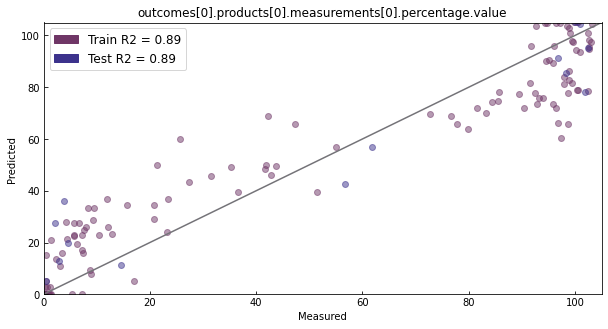

In [18]:
#Parity plots
fig, ax = aniline_bm.parity_plot(include_test=True)

# Run optimisation

In [20]:
def run_random(exp, max_iterations=10, random_state=np.random.RandomState(3)):
    exp.reset()
    strategy = Random(exp.domain, 
                    random_state=random_state)
    r = summit.Runner(strategy=strategy, 
                      experiment=exp, 
                      max_iterations=max_iterations)
    r.run()
    return r

def run_sobo(exp, max_iterations=10, categorical_method="one-hot"):
    exp.reset()
    strategy = SOBO(exp.domain, 
                    categorical_method=categorical_method)
    r = summit.Runner(strategy=strategy, 
                      experiment=exp, 
                      max_iterations=max_iterations)
    r.run()
    return r

def run_mtbo(exp, pt_data, max_iterations=10, task=1):
    exp.reset()
    strategy = MTBO(exp.domain, 
                    pretraining_data=pt_data,
                    categorical_method="one-hot", 
                    task=task)
    r = summit.Runner(strategy=strategy,
                      experiment=exp, 
                      max_iterations=max_iterations)
    r.run()
    return r


def make_average_plot(results: [summit.Runner], ax, label=None, color=None):
    objective = results[0].experiment.domain.output_variables[0].name
    yields = [r.experiment.data[objective] for r in results]
    yields = np.array(yields)
    mean_yield = np.mean(yields, axis=0)
    std_yield = np.std(yields, axis=0)
    x = np.arange(0, len(mean_yield), 1).astype(int)
    ax.plot(x, mean_yield, label=label, linewidth=2, color=color)
    ax.fill_between(x, mean_yield-std_yield, mean_yield+std_yield, alpha=0.1, color=color)

def make_comparison_plot(*args):
    fig, ax = plt.subplots(1)
    for arg in args:
        make_average_plot(arg['results'], ax, label=arg["label"], color=arg["color"])
    fontdict = fontdict={"size":12}
    ax.legend(loc = "lower right", prop=fontdict)
    ax.set_xlim(0,20)
    ax.set_xticks(np.arange(0, 20, 2).astype(int))
    ax.set_ylabel('Yield', fontdict=fontdict)
    ax.set_xlabel('Reactions', fontdict=fontdict)
    ax.tick_params(direction='in')
    return fig, ax

In [21]:
N_REPEATS = 10
MAX_ITERATIONS = 20

In [29]:
#Random
for i in range(N_REPEATS):
    print(f"Repeat {i}")
    exp = aniline_bm
    result = run_random(exp, max_iterations=MAX_ITERATIONS)
    result.save(f"results/aniline_random_{i}.json")
    clear_output(wait=True)

Repeat 9


In [30]:
#Single-Objective Bayesian Optimization
for i in range(N_REPEATS):
    print(f"Repeat {i}")
    exp = aniline_bm
    result = run_sobo(exp, max_iterations=MAX_ITERATIONS)
    result.save(f"results/aniline_SOBO_{i}.json")
    clear_output(wait=True)

Repeat 9


In [33]:
#Multi-Task Bayesian Optimization: 10 pretraining points
for i in range(10):
    print(f"Repeat {i}")
    exp = aniline_bm
    result = run_mtbo(exp, benzamide_ds[0:10], max_iterations=MAX_ITERATIONS, task=1)
    result.save(f"results/MTBO_10_{i}.json")
    clear_output(wait=True)

Repeat 9


In [39]:
#Multi-Task Bayesian Optimization: 50 pretraining points
for i in range(10):
    print(f"Repeat {i}")
    exp = aniline_bm
    result = run_mtbo(exp, benzamide_ds[0:50], max_iterations=MAX_ITERATIONS, task=1)
    result.save(f"results/MTBO_50_{i}.json")
    clear_output(wait=True)

Repeat 1


NotPSDError: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04.

In [34]:
random_results = [summit.Runner.load(f"results/aniline_random_{i}.json") for i in range(10)]
sobo_results = [summit.Runner.load(f"results/aniline_SOBO_{i}.json") for i in range(10)]
mtbo10_results = [summit.Runner.load(f"results/MTBO_10_{i}.json") for i in range(10)]
#mtbo50_results = [summit.Runner.load(f"results/MTBO_50_{i}.json") for i in range(10)]

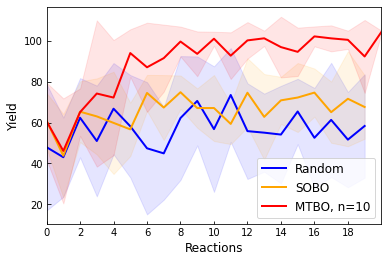

In [37]:
fig, ax = make_comparison_plot(
    dict(results=random_results, label="Random", color = 'blue'),
    dict(results=sobo_results, label="SOBO", color = 'orange'),
    dict(results=mtbo10_results, label="MTBO, n=10", color = 'red')
    #,
    #dict(results=mtbo50_results, label="MTBO, n=50", color = 'red')
)
